# Predicting Delinquency in Credit Card Payments

## Background

Anticipating credit card delinquency has become a widely adopted risk management technique in the financial industry. This methodology relies on analyzing personal information and historical data pertaining to credit card holders to evaluate the probability of future payment defaults and delinquencies. This targeted approach allows for a more precise evaluation of the risk associated with extending credit to applicants, enabling effective risk control measures to be implemented.

This analysis involves the utilization of two datasets: one comprising applications with essential client information, and the other focusing on credit-related data, specifically examining the variables `MONTHS_BALANCE` and `STATUS`. The purpose of this notebook is to conduct preliminary exploratory data analysis on the raw data, aiming to assess data integrity. Furthermore, we have performed feature engineering to generate additional columns, including `is_delinquent` and `length_of_credit`, among others, in order to gain deeper insights into the dataset.

#### Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
applications = pd.read_csv('../data/application_record.csv')
applications.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
credits = pd.read_csv('../data/credit_record.csv')
credits.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


The variable `STATUS` is defined this way:
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month 
- X: No loan for the month

A significant proportion of individuals in the sample do not have debt which indicates unbalanced data.

In [4]:
credits.STATUS.value_counts(normalize=True)

C    0.421554
0    0.365372
X    0.199537
1    0.010576
5    0.001615
2    0.000828
3    0.000305
4    0.000213
Name: STATUS, dtype: float64

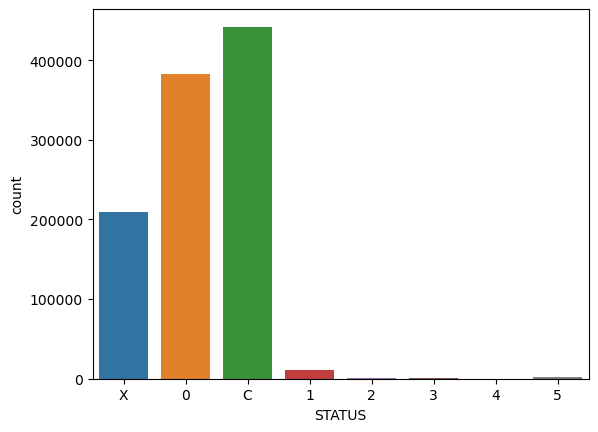

In [5]:
sns.countplot(x = credits['STATUS']);

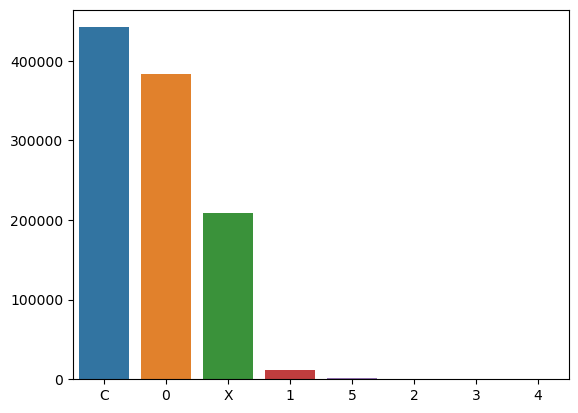

In [6]:
grouped = credits['STATUS'].value_counts()
sns.barplot(x=grouped.index, y=grouped.values);

In [7]:
credits.shape

(1048575, 3)

In [8]:
applications.shape

(438557, 18)

In [9]:
credits['ID'].nunique()

45985

The credit dataset encompasses a substantial volume of data, comprising over one million observations, while the application dataset contains more than 400,000 observations. Within the credit data, approximately 46,000 unique IDs are identified, indicating the presence of distinct individuals.

In [10]:
applications['ID'].nunique()

438510

In [11]:
len(set(applications['ID']).intersection(set(credits['ID'])))

36457

In [12]:
len(set(applications['ID']).difference(set(credits['ID'])))

402053

In [13]:
len(set(credits['ID']).difference(set(applications['ID'])))

9528

To ensure data consistency and comparability, the final sample is constructed by retaining only those observations that are common to both the application and credit datasets. This process yields over 36,000 unique applications that possess corresponding entries.

In [14]:
applications.groupby('ID')['ID'].count().value_counts()


1    438463
2        47
Name: ID, dtype: int64

There are 47 ID's that are repeated in the sample. Let's take a closer look into these observations. 

In [15]:
applications.groupby('ID').filter(lambda x: len(x) == 2)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
421211,7702516,F,N,Y,2,180000.0,Working,Secondary / secondary special,Married,House / apartment,-11753,-1256,1,1,1,0,Sales staff,4.0
421268,7602432,M,N,Y,0,315000.0,Commercial associate,Higher education,Civil marriage,House / apartment,-16627,-1304,1,0,1,0,Drivers,2.0
421349,7602432,F,N,N,0,117000.0,Pensioner,Higher education,Married,House / apartment,-24708,365243,1,0,0,0,NaN,2.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
421698,7213374,M,Y,N,0,148500.0,Working,Secondary / secondary special,Married,House / apartment,-9950,-961,1,0,1,0,Laborers,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433158,7282535,F,N,Y,0,63000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21124,365243,1,0,1,0,NaN,2.0
433159,7742853,M,N,Y,0,157500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15052,-1695,1,0,0,0,Laborers,1.0
433217,7135270,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,NaN,2.0
433666,7091721,F,Y,Y,0,90000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14116,-2269,1,0,0,0,Medicine staff,2.0


In [16]:
applications.duplicated().sum()

0

In [17]:
credits.duplicated().sum()

0

It becomes evident that a substantial disparity exists among the duplicated IDs and we have deemed it unreasonable to retain such instances within the sample. However, it is important to note that no complete duplicates were identified within the samples.

In [18]:
applications.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

The only feature with missing values is `OCCUPATION_TYPE`. We will return to this for a more detailed assessment.

In [19]:
credits.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

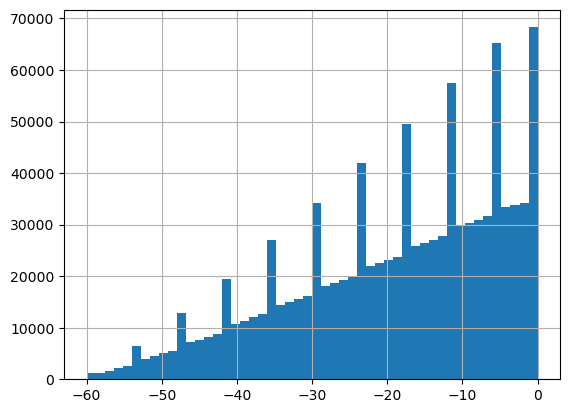

In [20]:
credits['MONTHS_BALANCE'].hist(bins=50);

There seems to be an oddity in the data with a jump in months balance roughly every 6 months.

In [21]:
credits.groupby('ID')['MONTHS_BALANCE'].count().sort_values()

ID
5105073     1
5095685     1
5022122     1
5061673     1
5116407     1
           ..
5010021    61
5011920    61
5024819    61
5010943    61
5005421    61
Name: MONTHS_BALANCE, Length: 45985, dtype: int64

The information above shows the length of the credit record for each unique ID in the sample. The length of credit can be as low as 1 to as high as 61 months.  

In [22]:
credits['is_delinquent'] = np.where(credits['STATUS'].isin(['C', 'X']), 0, 1)

In [23]:
credits.head()

,ID,MONTHS_BALANCE,STATUS,is_delinquent
0,5001711,0,X,0
1,5001711,-1,0,1
2,5001711,-2,0,1
3,5001711,-3,0,1
4,5001712,0,C,0


In [24]:
credits=credits.drop(columns='STATUS')

As part of our data cleaning process, we are using groupby and transfrom function to add within group statistics to the original dataset. [source](https://www.statology.org/pandas-groupby-transform/) 

In [25]:
credits['length_of_credit'] = credits.groupby('ID')['MONTHS_BALANCE'].transform('count')
credits.head()

,ID,MONTHS_BALANCE,is_delinquent,length_of_credit
0,5001711,0,0,4
1,5001711,-1,1,4
2,5001711,-2,1,4
3,5001711,-3,1,4
4,5001712,0,0,19


In [26]:
credits['number_of_delinquent_months'] = credits.groupby('ID')['is_delinquent'].transform('sum')
credits['average_delinquency_rate'] = credits.groupby('ID')['is_delinquent'].transform('mean')

credits.head()

,ID,MONTHS_BALANCE,is_delinquent,length_of_credit,number_of_delinquent_months,average_delinquency_rate
0,5001711,0,0,4,3,0.750000
1,5001711,-1,1,4,3,0.750000
2,5001711,-2,1,4,3,0.750000
3,5001711,-3,1,4,3,0.750000
4,5001712,0,0,19,10,0.526316


In [27]:
credits['month_rank'] = credits.groupby('ID')['MONTHS_BALANCE'].transform('rank')

credits.head()

,ID,MONTHS_BALANCE,is_delinquent,length_of_credit,number_of_delinquent_months,average_delinquency_rate,month_rank
0,5001711,0,0,4,3,0.750000,4.0
1,5001711,-1,1,4,3,0.750000,3.0
2,5001711,-2,1,4,3,0.750000,2.0
3,5001711,-3,1,4,3,0.750000,1.0
4,5001712,0,0,19,10,0.526316,19.0


In [28]:
nlargest = credits.groupby('ID')['month_rank'].nlargest(3).reset_index(level=1, drop=True).reset_index()
nlargest.head()

,ID,month_rank
0,5001711,4.0
1,5001711,3.0
2,5001711,2.0
3,5001712,19.0
4,5001712,18.0


In [29]:
recent_3_credit_reports = credits.merge(nlargest, how='inner', on=['ID', 'month_rank'])
recent_3_credit_reports.head()

,ID,MONTHS_BALANCE,is_delinquent,length_of_credit,number_of_delinquent_months,average_delinquency_rate,month_rank
0,5001711,0,0,4,3,0.750000,4.0
1,5001711,-1,1,4,3,0.750000,3.0
2,5001711,-2,1,4,3,0.750000,2.0
3,5001712,0,0,19,10,0.526316,19.0
4,5001712,-1,0,19,10,0.526316,18.0


In [30]:
recent_3_credit_reports.shape

(136069, 7)

We created a smaller version of the sample where only the most recent 3 month of credit report are kept. The purpose is to calculate if the person has been delinquent in the past three month.

In [31]:
recent3 = recent_3_credit_reports.groupby('ID')['is_delinquent'].max().rename('3mo_delinquency')
credit_full = credits.merge(recent3, how='left', on='ID')
credit_full.head()

,ID,MONTHS_BALANCE,is_delinquent,length_of_credit,number_of_delinquent_months,average_delinquency_rate,month_rank,3mo_delinquency
0,5001711,0,0,4,3,0.750000,4.0,1
1,5001711,-1,1,4,3,0.750000,3.0,1
2,5001711,-2,1,4,3,0.750000,2.0,1
3,5001711,-3,1,4,3,0.750000,1.0,1
4,5001712,0,0,19,10,0.526316,19.0,0


In [32]:
credit_full.shape

(1048575, 8)

Instead of only creating is_delinquent, we can create 3, 6, and 12 months as well. For that, we are creating a function which is included in the functions.py.

In [33]:
credit_full.sort_values(['ID', 'MONTHS_BALANCE'], ascending=[True, False]).drop_duplicates(subset='ID', keep='first').drop(columns=['MONTHS_BALANCE', 'month_rank'])

,ID,is_delinquent,length_of_credit,number_of_delinquent_months,average_delinquency_rate,3mo_delinquency
0,5001711,0,4,3,0.750000,1
4,5001712,0,19,10,0.526316,0
23,5001713,0,22,0,0.000000,0
45,5001714,0,15,0,0.000000,0
60,5001715,0,60,0,0.000000,0
...,...,...,...,...,...,...
1048494,5150482,0,18,12,0.666667,0
1048512,5150483,0,18,0,0.000000,0
1048530,5150484,0,13,12,0.923077,1
1048543,5150485,1,2,2,1.000000,1


In [34]:
credit_full = credit_full.sort_values(['ID', 'MONTHS_BALANCE'], ascending=[True, False])
credit_cleaned = credit_full.drop_duplicates(subset='ID', keep='first').drop(columns=['MONTHS_BALANCE', 'month_rank'])
credit_cleaned.head()

,ID,is_delinquent,length_of_credit,number_of_delinquent_months,average_delinquency_rate,3mo_delinquency
0,5001711,0,4,3,0.750000,1
4,5001712,0,19,10,0.526316,0
23,5001713,0,22,0,0.000000,0
45,5001714,0,15,0,0.000000,0
60,5001715,0,60,0,0.000000,0


In [35]:
applications.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


We are dropping gender from the sample to avoid systemic bias in our model predictions and recommendations.

In [36]:
applications.drop(columns='CODE_GENDER', inplace=True)

In [37]:
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    applications[col] = np.where(applications[col]=='Y', 1, 0)

In [38]:
applications['NAME_INCOME_TYPE'].value_counts()

Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: NAME_INCOME_TYPE, dtype: int64

In [39]:
applications['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: NAME_EDUCATION_TYPE, dtype: int64

In [40]:
applications['NAME_FAMILY_STATUS'].value_counts()

Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: NAME_FAMILY_STATUS, dtype: int64

In [41]:
applications['NAME_HOUSING_TYPE'].value_counts()

House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: NAME_HOUSING_TYPE, dtype: int64

In [42]:
applications['OCCUPATION_TYPE'].value_counts(dropna=False, normalize=False)

NaN                      134203
Laborers                  78240
Core staff                43007
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: OCCUPATION_TYPE, dtype: int64

Returning to the missing values in `OCCUPATION_TYPE`, we were able to determine a portion of these were due to retirement, for the remaining missing values we created a new label called 'missing'.

In [43]:
applications.groupby('OCCUPATION_TYPE', dropna=False)['AMT_INCOME_TOTAL'].mean().sort_values()

OCCUPATION_TYPE
Cleaning staff           147064.463815
Low-skill Laborers       150334.309346
Cooking staff            155848.425334
Waiters/barmen staff     158796.621622
Medicine staff           168102.197707
Secretaries              169456.878669
Security staff           169835.113662
NaN                      170869.803331
Sales staff              170912.759267
Laborers                 179865.810449
Core staff               190905.844378
High skill tech staff    195712.011010
Private service staff    201600.651042
Drivers                  202065.242047
HR staff                 203620.686047
IT staff                 210958.733444
Accountants              215137.274977
Realty agents            223510.806916
Managers                 282125.938701
Name: AMT_INCOME_TOTAL, dtype: float64

In [44]:
applications['OCCUPATION_TYPE'] = applications['OCCUPATION_TYPE'].fillna('missing')

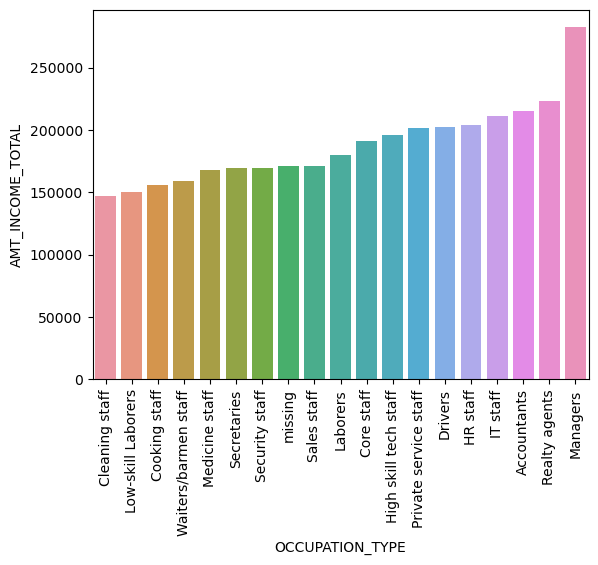

In [45]:
grouped = applications.groupby('OCCUPATION_TYPE')['AMT_INCOME_TOTAL'].mean().sort_values()
sns.barplot(x=grouped.index, y=grouped)
plt.xticks(rotation=90);

The income values here look suspicious as they are very close to one another without much difference between occupation types. This may challenge the integerity of the data.

In [46]:
applications[applications['DAYS_EMPLOYED'] > 0].value_counts().sum()

75329

In [47]:
applications['DAYS_EMPLOYED'] = np.where(applications['DAYS_EMPLOYED'] > 0, 0, applications['DAYS_EMPLOYED'])

In [48]:
applications[applications['DAYS_EMPLOYED'] == 0].value_counts().sum()

75329

In [49]:
applications['OCCUPATION_TYPE'] = np.where(applications['DAYS_EMPLOYED'] == 0, 'Retired', applications['OCCUPATION_TYPE'])

In [50]:
applications[applications['DAYS_EMPLOYED'] == 0].head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
7,5008812,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,0,1,0,0,0,Retired,1.0
8,5008813,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,0,1,0,0,0,Retired,1.0
9,5008814,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,0,1,0,0,0,Retired,1.0
76,5008884,0,1,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,0,1,0,0,0,Retired,1.0
160,5008974,0,1,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22319,0,1,0,0,0,Retired,2.0


In [51]:
applications['AGE'] = (abs(applications['DAYS_BIRTH']) / 365).astype(int)
applications['YEARS_EMPLOYED'] = (abs(applications['DAYS_EMPLOYED']) / 365).astype(int)
applications.drop(columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace = True)

The columns `DAYS_EMPLOYED` and `DAYS_BIRTH` do not provide very valuable human readable information, therefore we have deleted these columns and created new features in relation to years. 

In [52]:
data_merged = credit_cleaned.merge(applications, how='inner', on='ID')
print(data_merged.shape)
data_merged.head(10)

(36457, 22)


,ID,is_delinquent,length_of_credit,number_of_delinquent_months,average_delinquency_rate,3mo_delinquency,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
0,5008804,0,16,2,0.125000,0,1,1,0,427500.0,...,Civil marriage,Rented apartment,1,1,0,0,missing,2.0,32,12
1,5008805,0,15,2,0.133333,0,1,1,0,427500.0,...,Civil marriage,Rented apartment,1,1,0,0,missing,2.0,32,12
2,5008806,0,30,7,0.233333,0,1,1,0,112500.0,...,Married,House / apartment,1,0,0,0,Security staff,2.0,58,3
3,5008808,1,5,2,0.400000,1,0,1,0,270000.0,...,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
4,5008809,0,5,0,0.000000,0,0,1,0,270000.0,...,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
5,5008810,0,27,6,0.222222,0,0,1,0,270000.0,...,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
6,5008811,0,39,6,0.153846,0,0,1,0,270000.0,...,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
7,5008812,1,17,14,0.823529,1,0,1,0,283500.0,...,Separated,House / apartment,1,0,0,0,Retired,1.0,61,0
8,5008813,1,17,14,0.823529,1,0,1,0,283500.0,...,Separated,House / apartment,1,0,0,0,Retired,1.0,61,0
9,5008814,1,17,14,0.823529,1,0,1,0,283500.0,...,Separated,House / apartment,1,0,0,0,Retired,1.0,61,0


In [53]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           36457 non-null  int64  
 1   is_delinquent                36457 non-null  int64  
 2   length_of_credit             36457 non-null  int64  
 3   number_of_delinquent_months  36457 non-null  int64  
 4   average_delinquency_rate     36457 non-null  float64
 5   3mo_delinquency              36457 non-null  int64  
 6   FLAG_OWN_CAR                 36457 non-null  int64  
 7   FLAG_OWN_REALTY              36457 non-null  int64  
 8   CNT_CHILDREN                 36457 non-null  int64  
 9   AMT_INCOME_TOTAL             36457 non-null  float64
 10  NAME_INCOME_TYPE             36457 non-null  object 
 11  NAME_EDUCATION_TYPE          36457 non-null  object 
 12  NAME_FAMILY_STATUS           36457 non-null  object 
 13  NAME_HOUSING_TYP

In [54]:
data_merged

,ID,is_delinquent,length_of_credit,number_of_delinquent_months,average_delinquency_rate,3mo_delinquency,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
0,5008804,0,16,2,0.125000,0,1,1,0,427500.0,...,Civil marriage,Rented apartment,1,1,0,0,missing,2.0,32,12
1,5008805,0,15,2,0.133333,0,1,1,0,427500.0,...,Civil marriage,Rented apartment,1,1,0,0,missing,2.0,32,12
2,5008806,0,30,7,0.233333,0,1,1,0,112500.0,...,Married,House / apartment,1,0,0,0,Security staff,2.0,58,3
3,5008808,1,5,2,0.400000,1,0,1,0,270000.0,...,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
4,5008809,0,5,0,0.000000,0,0,1,0,270000.0,...,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5150482,0,18,12,0.666667,0,1,1,1,157500.0,...,Married,House / apartment,1,0,0,0,Core staff,3.0,29,4
36453,5150483,0,18,0,0.000000,0,1,1,1,157500.0,...,Married,House / apartment,1,0,0,0,Core staff,3.0,29,4
36454,5150484,0,13,12,0.923077,1,1,1,1,157500.0,...,Married,House / apartment,1,0,0,0,Core staff,3.0,29,4
36455,5150485,1,2,2,1.000000,1,1,1,1,157500.0,...,Married,House / apartment,1,0,0,0,Core staff,3.0,29,4


Here we merge both datasets along the 36,457 unique ID's shared between both datasets for a master dataset.

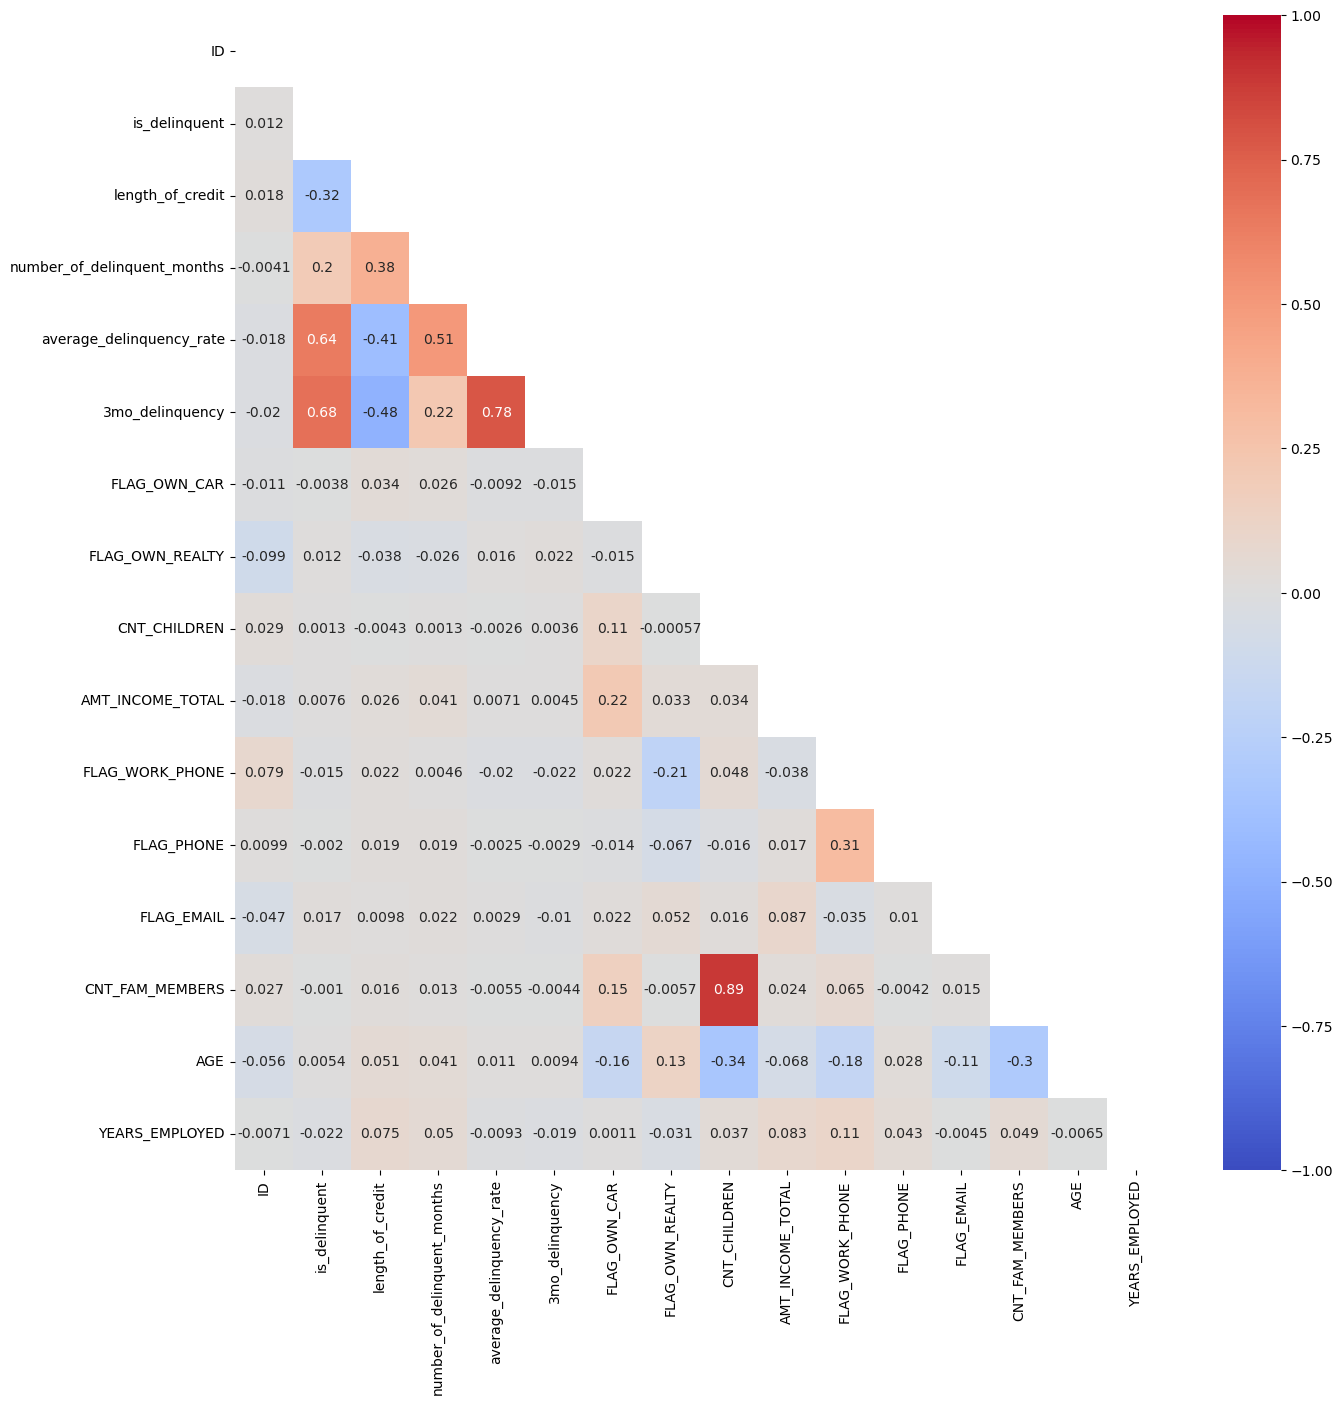

In [55]:
numericals = list(data_merged.select_dtypes(include=['int64', 'float64']).columns)
numericals.remove('FLAG_MOBIL')
plt.figure(figsize=(15, 15))
mask = np.triu(np.ones_like(data_merged[numericals].corr()))
sns.heatmap(data_merged[numericals].corr(), mask=mask, cmap='coolwarm',
            vmin = -1, vmax=1,annot=True);

Here we see some unimportant correlations such as count of children and family count. However, there are some interesting negative correlations with length of credit and delinquency.

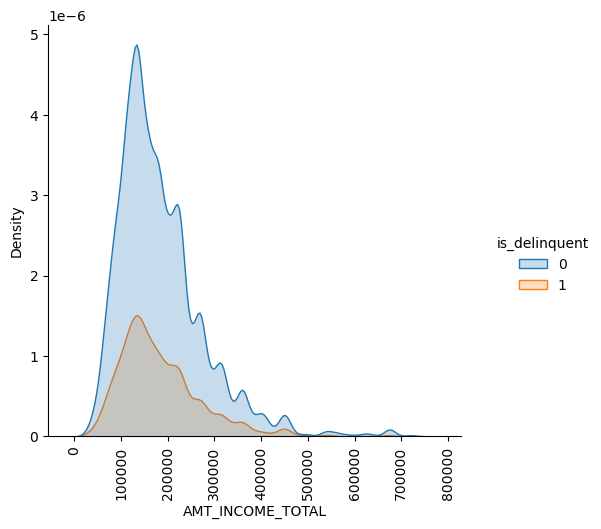

In [56]:
sns.displot(data_merged[data_merged['AMT_INCOME_TOTAL']<0.75e6], x="AMT_INCOME_TOTAL", hue="is_delinquent", kind="kde", fill=True)
plt.xticks(rotation = 90);

In [57]:
data_merged.columns

Index(['ID', 'is_delinquent', 'length_of_credit',
       'number_of_delinquent_months', 'average_delinquency_rate',
       '3mo_delinquency', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED'],
      dtype='object')

<Axes: xlabel='AGE', ylabel='Density'>

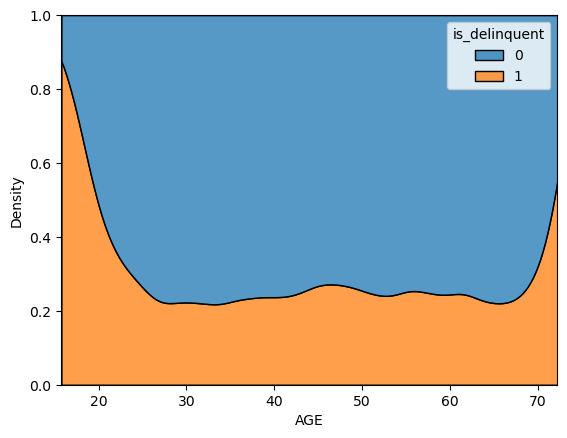

In [58]:
sns.kdeplot(data=data_merged, x="AGE", hue="is_delinquent", multiple="fill")

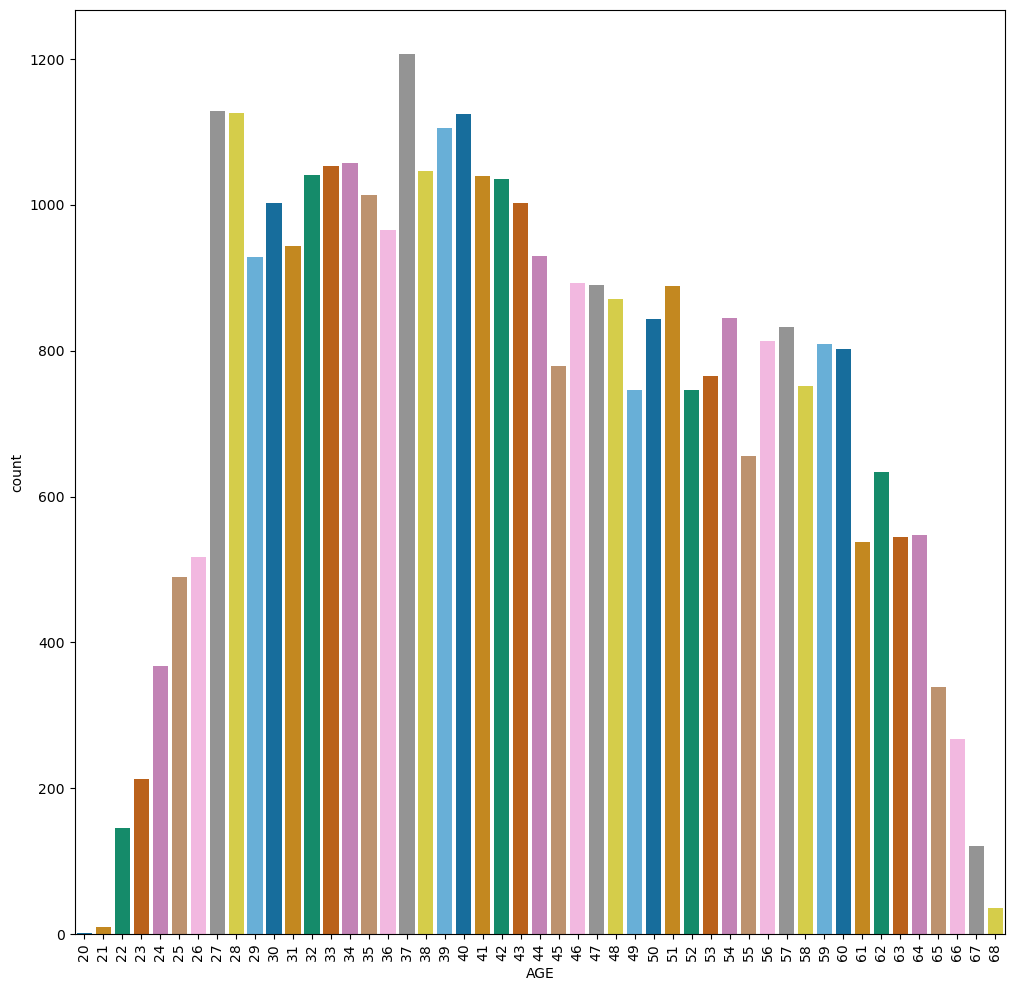

In [59]:
plt.figure(figsize=(12, 12))
sns.countplot(data = data_merged, x='AGE', palette='colorblind')
plt.xticks(rotation = 90);